In [53]:
%%time

import boto3
import findspark
import os
from sqlalchemy import create_engine
import logging
from sqlalchemy import MetaData
from sqlalchemy import create_engine, inspect
from sqlalchemy.engine.url import URL
from sqlalchemy.ext.declarative import declarative_base
import pandas as pd
from sqlalchemy.orm import sessionmaker
from scipy import stats
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from joblib import Parallel
from joblib import delayed
from itertools import product
from multiprocessing import cpu_count
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

#HOST = os.environ['HOST']
#USERNAME = os.environ['USERNAME']
#PASSWORD = os.environ['PASSWORD']
#PORT = os.environ['PORT']
#DATABASE_NAME = os.environ['DATABASE_NAME']

# Definir string de conexão com o banco de dados

#CONNECTION = f'postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}/{DATABASE_NAME}'

# Criar engine para acesso ao banco de dados
#engine = create_engine(
#    CONNECTION
#)

#print("Conexão com banco de dados estabelecida")

#SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
#Base = declarative_base()

#db = SessionLocal()

#metadata = MetaData()
#metadata.reflect(bind=engine)

#print("Dados das tabelas refletidos com sucesso")

CPU times: user 257 µs, sys: 56 µs, total: 313 µs
Wall time: 328 µs


In [ ]:
### dataframe dos resultados diretamente do banco ###

#query ao banco para retornar todos os resultados do indicador pacientes agendadados
df_resultados = pd.DataFrame(db.query(metadata.tables['resultados']).filter(metadata.tables['resultados'].c.indicador_id==160).all())

#coletar as colunas dos metadados da tabela
df_resultados.columns = metadata.tables['resultados'].columns.keys()

#fechar conexão com o banco
db.close()

# padronizar e sortear em ordem crescente os valores de data 
df_resultados = df_resultados.rename(columns={"dia": "Date"})
df_resultados = df_resultados[['Date', 'resultado']]
df_resultados['Date'] = pd.to_datetime(df_resultados['Date'])
df_resultados = df_resultados.sort_values(by="Date")

# retornar o dataframe com os resultados
df_resultados

In [33]:
df_resultados

,Date,resultado
18,2021-01-12,14
19,2021-02-12,13
20,2021-03-12,18
21,2021-04-12,2
22,2021-06-12,16
...,...,...
53,2022-12-01,20
79,2022-12-02,5
100,2022-12-03,7
125,2022-12-04,8


In [37]:
### dataframe dos resultados acesso via csv ###

df_resultados = pd.read_csv('dados.csv',delimiter=',')

# padronizar e sortear em ordem crescente os valores de data 
df_resultados = df_resultados.rename(columns={"dia": "Date"})
df_resultados = df_resultados[['Date', 'resultado']]
df_resultados['Date'] = pd.to_datetime(df_resultados['Date'])
df_resultados = df_resultados.sort_values(by="Date")

# retornar o dataframe com os resultados
df_resultados

,Date,resultado
0,2021-11-09,8.0
1,2021-11-10,13.0
2,2021-11-11,22.0
3,2021-11-12,16.0
4,2021-11-13,6.0
...,...,...
152,2022-05-17,26.0
153,2022-05-18,15.0
154,2022-05-19,13.0
155,2022-05-20,16.0


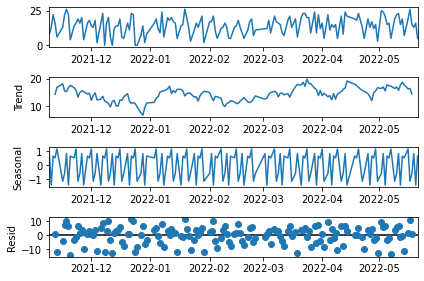

In [38]:
data = df_resultados.set_index(['Date'])

#Estudo da sazonalidade com períodos de 7 dias
result = seasonal_decompose(data, model='additive', period=7)
result.plot()
plt.show()

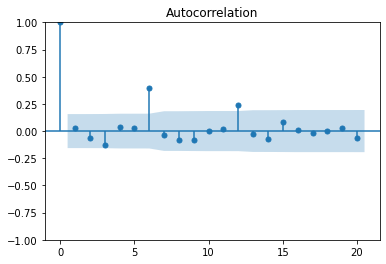

In [39]:
# Calculo do ACF via statsmodels
plot_acf(data, lags=20)

# Estudo da autocorrelação dos resultados
plt.show()

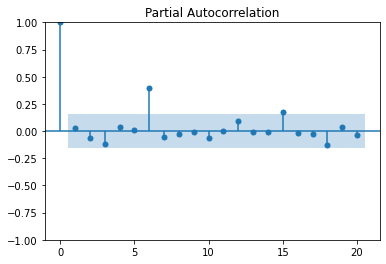

In [41]:
# Calculo do PACF via statsmodels
plot_pacf(data, lags=20, method='ywm')

# Estudo da autocorrelação parcial dos resultados
plt.show()

In [42]:
def create_date_table(start='2000-01-01', end='2050-12-31'):
        start_ts = pd.to_datetime(start).date()

        end_ts = pd.to_datetime(end).date()

        # record timetsamp is empty for now
        dates = pd.DataFrame(columns=['Record_timestamp'],
                             index=pd.date_range(start_ts, end_ts, freq='D'))
        dates.index.name = 'Date'
        days_names = {
            i: name
            for i, name
            in enumerate(['Monday', 'Tuesday', 'Wednesday',
                          'Thursday', 'Friday', 'Saturday',
                          'Sunday'])
        }

        dates['Day'] = dates.index.dayofweek
        dates['Month'] = dates.index.month
        del dates['Record_timestamp']
        dates['Year'] = dates.index.year
        dates.reset_index(inplace=True)
        return dates
    
df_calendar = create_date_table(df_resultados['Date'].iloc[0], df_resultados['Date'].iloc[-1])

df_calendar

,Date,Day,Month,Year
0,2021-11-09,1,11,2021
1,2021-11-10,2,11,2021
2,2021-11-11,3,11,2021
3,2021-11-12,4,11,2021
4,2021-11-13,5,11,2021
...,...,...,...,...
189,2022-05-17,1,5,2022
190,2022-05-18,2,5,2022
191,2022-05-19,3,5,2022
192,2022-05-20,4,5,2022


In [44]:
# fazer o merge da tabela resultados com a tabela calendário e a dummização das colunas criadas na tabela calendário

df_timeseries = df_calendar.merge(df_resultados, on='Date', how='left')
df_timeseries = df_timeseries.fillna(0)
df_timeseries.index = pd.to_datetime(df_timeseries['Date'], format='%Y-%m-%d')
del df_timeseries['Date']

try:
    df_timeseries.index.freq = 'd'
except Exception as e:
    pass

df_timeseries = pd.get_dummies(df_timeseries, columns=['Month', 'Day', 'Year'], prefix=['Month', 'Day', 'Year'])

ext_var_list = df_timeseries.drop(columns=['resultado']).columns

df_timeseries

,resultado,Month_1,Month_2,Month_3,Month_4,Month_5,Month_11,Month_12,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Year_2021,Year_2022
Date,,,,,,,,,,,,,,,,,
2021-11-09,8.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2021-11-10,13.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2021-11-11,22.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2021-11-12,16.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
2021-11-13,6.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-17,26.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
2022-05-18,15.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2022-05-19,13.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [48]:
#criação da função que testa a estacionaridade da série temporal e para identificar o parâmetro d do algorítmo

def test_stationarity(timeseries, cutoff=0.01):
        # Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC', maxlag=20)
        dfoutput = pd.Series(dftest[0:4], index=[
                             'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        pvalue = dftest[1]
        if pvalue < cutoff:
            print('p-value = %.4f. The series is likely stationary.' % pvalue)
        else:
            print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

        print(dfoutput)

        return pvalue

def identify_parameter_d(results):
    d = 0
    non_stacionary = True
    results = results
    while non_stacionary:
        pvalue = test_stationarity(results)
        results = results - results.shift(1)
        results = results.dropna(inplace=False)
        if pvalue <= 0.05:
            non_stacionary = False
        else:
            d += 1
    print("Parameter d:", d)
    return d

In [85]:
#separar o treino em treino e teste com 80% das observações para o dataset de treino e 20% para o dataset de teste

def split_dfs(df): 
    df = df.sort_values(by='Date') 
    trainvals = df[:int(len(df)*0.8)] 
    testvals = df[int(len(df)*0.8):] 

    return {'train': trainvals, 'test': testvals}

train = split_dfs(df_timeseries)['train']
test = split_dfs(df_timeseries)['test']

print(train.head())

print(test.head())

            resultado  Month_1  Month_2  Month_3  Month_4  Month_5  Month_11  \
Date                                                                           
2021-11-09        8.0        0        0        0        0        0         1   
2021-11-10       13.0        0        0        0        0        0         1   
2021-11-11       22.0        0        0        0        0        0         1   
2021-11-12       16.0        0        0        0        0        0         1   
2021-11-13        6.0        0        0        0        0        0         1   

            Month_12  Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  \
Date                                                                    
2021-11-09         0      0      1      0      0      0      0      0   
2021-11-10         0      0      0      1      0      0      0      0   
2021-11-11         0      0      0      0      1      0      0      0   
2021-11-12         0      0      0      0      0      1      0      0   
2

In [86]:
# definir precisão do algorítmo

precision = 5

# Transformação Box-Cox nos valores observados

k2, p = stats.normaltest(df_timeseries['resultado'])

print("p = {:g}".format(p))

alpha = 0.05

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print(" x comes from a normal distribution")
else:
    df_timeseries.loc[df_timeseries['resultado']
                      == 0, 'resultado'] = 0.0001
    xt, lmbda = stats.boxcox(df_observed['resultado'])
    df_timeseries['resultado'] = xt

# valores de p quer serão utilizados na avaliação do melhor modelo
p_values = np.arange(precision)
# valores de d quer serão utilizados na avaliação do melhor modelo
d_values = np.arange(identify_parameter_d(train['resultado'])+1)
# valores de q quer serão utilizados na avaliação do melhor modelo
q_values = np.arange(precision)

# estabelecer uma lista com todas as combinações possíveis nos valores de p,d e q através de um produto vetorial
possibilities = list(product(p_values, d_values, q_values))

# estabelecer uma conexão multitarefa de execução com todos os cores disponíveis na cpu
executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')

print(executor)

# definir a lista que irá receber os os resultados da avaliação dos modelos
scores = []

print(possibilities)

p = 6.8509e-29
 x comes from a normal distribution
Results of Dickey-Fuller Test:
p-value = 0.0128. The series is likely non-stationary.
Test Statistic                  -3.349908
p-value                          0.012790
#Lags Used                       8.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64
Parameter d: 0
Parallel(n_jobs=8)
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4)]


In [87]:
# função que receberá os todas as possibilidades dos parâmetros para retornar os resultados dos modelos ARIMA
def evaluate_arima(parameters, data):
    # modelo ARIMA da biblioteca Statsmodels com os parâmetros de entrada
    model = ARIMA(endog=data.resultado,  # atributo target
                  # outros atributos para melhorar a compor o modelo
                  exog=data[ext_var_list],
                  # parâmetros p, d e q de entrada
                  order=(parameters[0], parameters[1], parameters[2])
                  ).fit()
    
    aic = model.aic

    # retornar o SMAPE resultante dos fitted values do modelo e os valores observados
    # smape = np.mean((np.abs(model.fittedvalues - data.resultado) * 200 /
    #                (np.abs(model.fittedvalues) + np.abs(data.resultado))).fillna(0))

    smape = 1/len(data.resultado) * np.sum(2 * np.abs(model.fittedvalues -
                                                      data.resultado) / (np.abs(data.resultado) + np.abs(model.fittedvalues))*100)
    mse = mean_squared_error(data.resultado, model.fittedvalues)
    mae = mean_absolute_error(data.resultado, model.fittedvalues)
    mape = mean_absolute_percentage_error(data.resultado, model.fittedvalues)
    rmse = sqrt(mse)

    # retornar para o usuário em tempo de execução
    print({'Order': parameters,
           'AIC': str(round(aic)),
           'RMSE': str(round(rmse, 2)),
           'MAE': str(round(mae, 2))+"%",
           'MAPE': str(round(mape, 2))+"%",
           'SMAPE': str(round(smape, 2))+"%"})

    # retornar os parâmetros (p,d,q) utilizados, o AIC do modelo e o resultado do SMAPE
    return parameters, round(aic, 2), round(rmse, 2), round(mae, 2), round(mape, 2), round(smape, 2)

try:
    # definir as tarefas que serão executadas em paralelos de acordo com as possibilidades encontradas no produto vetorial dos parâmetros
    tasks = (delayed(evaluate_arima)(i, train) for i in possibilities)
    # objeto que receberá as execuções das tarefas
    results = executor(tasks)
    # adicionar na lista scores os resultados dos modelos de todas as possibilidades
    scores.append(results)
except Exception as e:
    # printar algum erro caso ocorra
    print(e)

# atribuir os resultados no objeto results
results = scores[0]

# sortear a ordem dos resultados pelo melhor valor de RMSE
results.sort(key=lambda item: item[2])

# mostrar para o usuário os melhores valores de erro
print("Best AIC: ", str(round(results[0][1], 2)))
print("Best RMSE: ", str(round(results[0][2], 2)))
print("Best MAE: ", str(round(results[0][3], 2)))
print("Best MAPE: ", str(round(results[0][4], 2)))
print("Best SMAPE: ", str(round(results[0][5], 2)))

# rodar novamento o modelo com o melhor resultado e atribuir ao objeto model

model = ARIMA(endog=train.resultado,
              exog=train[ext_var_list],
              order=results[0][0])  # pegar o primeiro resultado sorteado como o melhor modelo na lista de resultados

# fazer o fit do modelo para obter os fitted values
model = model.fit()

# printar o sumário do modelo para o usuário
print(model.summary())

df_results = pd.DataFrame(results)
df_results.columns = ['Ordem', 'AIC', 'RMSE', 'MAE', 'MAPE', 'SMAPE']

print(df_results.head())

print(train.resultado.sum(), model.fittedvalues.sum())

{'Order': (1, 0, 0), 'AIC': '984', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4249976513589175.5%', 'SMAPE': '64.54%'}
{'Order': (0, 0, 0), 'AIC': '983', 'RMSE': '5.13', 'MAE': '3.73%', 'MAPE': '4354718545116209.5%', 'SMAPE': '64.19%'}
{'Order': (0, 0, 1), 'AIC': '984', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4244134462235859.0%', 'SMAPE': '64.55%'}
{'Order': (1, 0, 1), 'AIC': '986', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4245363229216527.5%', 'SMAPE': '64.55%'}
{'Order': (0, 0, 2), 'AIC': '986', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4245935785627141.0%', 'SMAPE': '64.55%'}
{'Order': (1, 0, 2), 'AIC': '988', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4247656797380096.0%', 'SMAPE': '64.54%'}
{'Order': (0, 0, 3), 'AIC': '988', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4266120158673487.5%', 'SMAPE': '64.45%'}
{'Order': (0, 0, 4), 'AIC': '990', 'RMSE': '5.12', 'MAE': '3.71%', 'MAPE': '4267561480269122.0%', 'SMAPE': '64.51%'}
{'Order': (2, 0, 0), 'AIC': '986', 'RMSE': '5.12', 'MAE': '3.71%

In [88]:
# guardando os fitted values no dataset de treino
train['y_hat']=model.fittedvalues

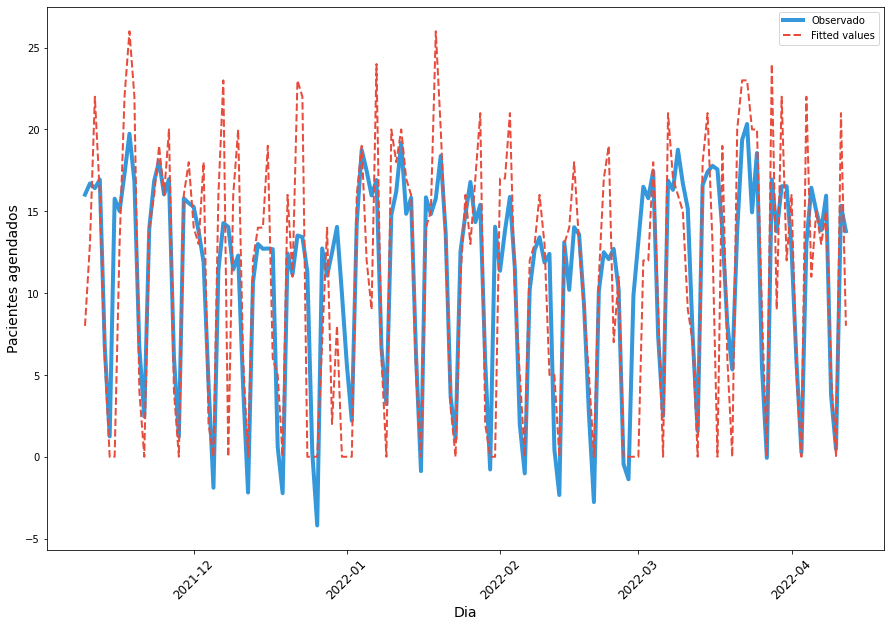

In [89]:
#visualização do fit do modelo vs observado no dataset de treino

plt.figure(figsize=(15,10))
plt.plot(train.y_hat, linewidth=4, color='#3498db')
plt.plot(train.resultado, linestyle='--', linewidth=2, color='#e74c3c')
plt.xlabel('Dia',fontsize=14)
plt.ylabel('Pacientes agendados',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.legend(['Observado','Fitted values'])
plt.show()

In [93]:
model_test = ARIMA(endog=test.resultado,
              exog=test[ext_var_list],
              order=results[0][0])  # pegar o primeiro resultado sorteado como o melhor modelo na lista de resultados

# fazer o fit do modelo para obter os fitted values
model_test = model_test.fit()

# printar o sumário do modelo para o usuário
print(model_test.summary())

                               SARIMAX Results                                
Dep. Variable:              resultado   No. Observations:                   39
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -106.900
Date:                Tue, 24 May 2022   AIC                            261.799
Time:                        14:05:59   BIC                            301.101
Sample:                    04-13-2022   HQIC                           275.783
                         - 05-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Month_1             0   2.11e+05          0      1.000   -4.14e+05    4.14e+05
Month_2      3.49e-18   2.11e+05   1.65e-23      1.000   -4.14e+05    4.14e+05
Month_3    -3.304e-18   2.11e+05  -1.57e-23      1.0

In [96]:
test['y_hat']=model_test.fittedvalues

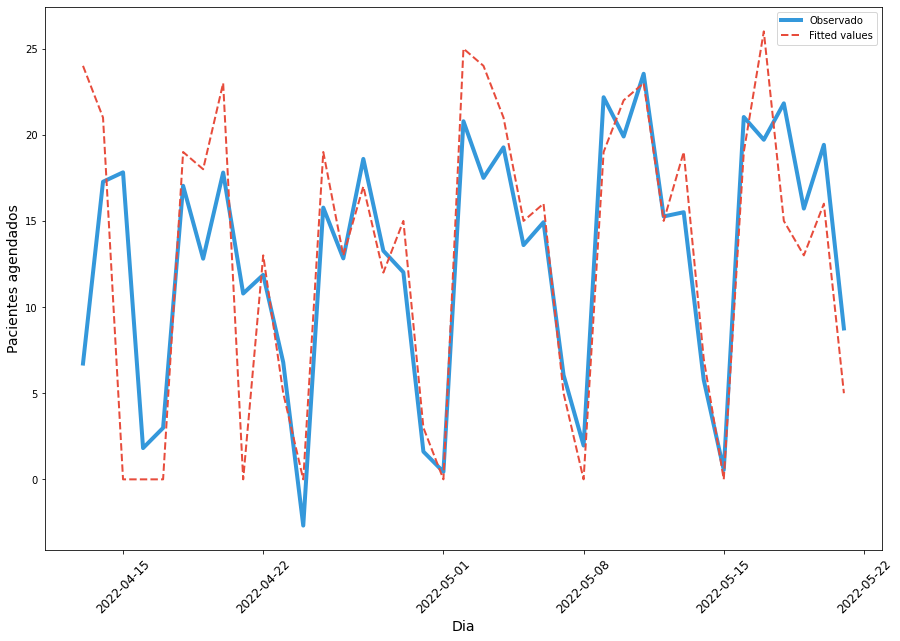

In [97]:
#visualização do fit do modelo vs observado no dataset de teste

plt.figure(figsize=(15,10))
plt.plot(test.y_hat, linewidth=4, color='#3498db')
plt.plot(test.resultado, linestyle='--', linewidth=2, color='#e74c3c')
plt.xlabel('Dia',fontsize=14)
plt.ylabel('Pacientes agendados',fontsize=14)
plt.xticks(rotation=45,fontsize=12)
plt.legend(['Observado','Fitted values'])
plt.show()

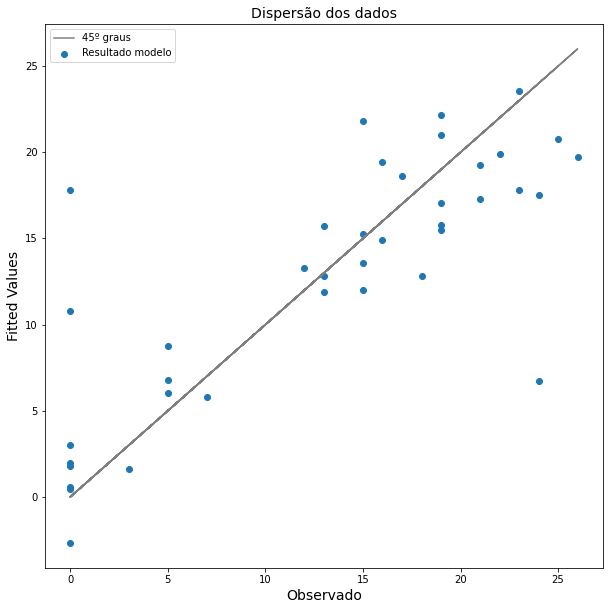

In [98]:
# Gráfico de dispersão com ajustes (fits) linear e valores observados

xdata = test.resultado
ydata_linear = test.y_hat

plt.figure(figsize=(10,10))
plt.plot(xdata,xdata, color='gray')
plt.scatter(xdata,ydata_linear)

plt.title('Dispersão dos dados',fontsize=14)
plt.xlabel('Observado',fontsize=14)
plt.ylabel('Fitted Values',fontsize=14)
plt.legend(['45º graus','Resultado modelo'])
plt.show()